In [854]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [855]:
import numpy as np 
import matplotlib.pyplot as plt
from module_2D_coupling_FV_nogrid import * 
import reconst_and_test_module as post
import random 
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg
#0-Set up the sources
plt.rcParams["figure.figsize"] = (12,12)

In [856]:


#1-Set up the domain
D=1
L=5
h_ss=1
#Rv=np.exp(-2*np.pi)*h_ss
Rv=0.01
C0=1
K_eff=1/(np.pi*Rv**2)

validation=False
real_Dirich=True
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(L//h_ss))
y_ss=x_ss

#pos_s=np.array([[x_ss[2], y_ss[2]],[x_ss[4], y_ss[4]]])
#pos_s=np.array([[3.5,3.8],[3.4,3.4], [4.1, 3.6],[2,2]])-np.array([0.25,0.25])
#pos_s/=2
#pos_s=np.array([[1.25,1.25],[1.25,1.75], [1.75,1.75],[1.75,1.25]])
#pos_s=np.array([[4.3,4.3],[4.3,5.5], [3.5,4.5],[3.5,3.5]])
S=6
pos_s=np.random.random((S,2))+2

#pos_s=np.array([[1.25,1.25]])+2.25
#pos_s=np.array([[1.25,1.25],[1.25,1.75]])
#pos_s=np.array([[3.5,3.8],[3.4,3.4], [4.1, 3.6]])-np.array([0.25,0.25])
#pos_s=np.array([[1.5,4.5]])-0.25

In [857]:
if real_Dirich:
    A=A_assembly(len(x_ss), len(y_ss))*D/h_ss**2
    #set dirichlet
    B,A=set_TPFA_Dirichlet(0,A, h_ss, get_boundary_vector(len(x_ss), len(y_ss)), np.zeros(len(x_ss)*len(y_ss)),D)
else:
    A=A_assembly_Dirich(len(x_ss), len(y_ss))*D/h_ss**2
    B=np.zeros(A.shape[0])
    

In [858]:
pos_s=np.array([[2.22, 2.18],
       [2.48, 2.10],
       [2.24, 2.86],
       [2.57 , 2.98],
       [2.65, 2.58],
       [2.67, 2.65]])


In [859]:
t=assemble_SS_2D_FD(pos_s, A, Rv, h_ss,x_ss,y_ss, K_eff, D)
t.pos_arrays()
t.initialize_matrices()


t.assembly_sol_split_problem()



array([[-10.        ,   1.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.        ,  -7.        ,   1.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   1.        ,  -7.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   1.        ,
         -0.59022448,  -0.56347756],
       [  0.        ,   0.        ,   0.        , ...,  -0.59022448,
          1.        ,  -0.31594579],
       [  0.        ,   0.        ,   0.        , ...,  -0.56347756,
         -0.31594579,   1.        ]])

In [860]:
B_v=np.zeros(len(t.uni_s_blocks))
B_q=np.array([1,0,0,1,0,1])
B=np.concatenate((B,B_v,B_q))



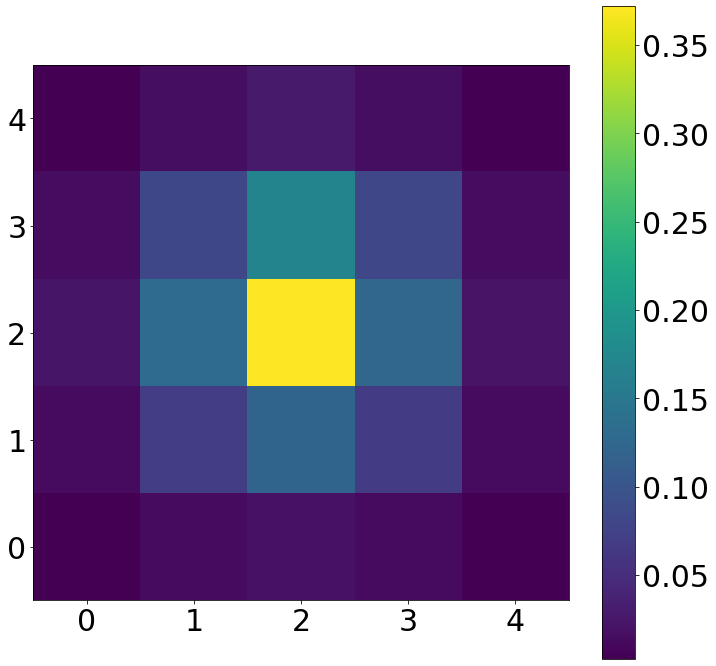

In [861]:

phi=np.linalg.solve(t.M, B)

phi_FV, phi_v, phi_q=post.separate_unk(t, phi)
phi_mat=phi_FV.reshape(len(x_ss), len(y_ss))

plt.imshow(phi_mat, origin="lower"); plt.colorbar()
plt.show()
Up=np.hstack((t.A, t.B_matrix, t.C1_matrix+t.C2_matrix))
ratio=20

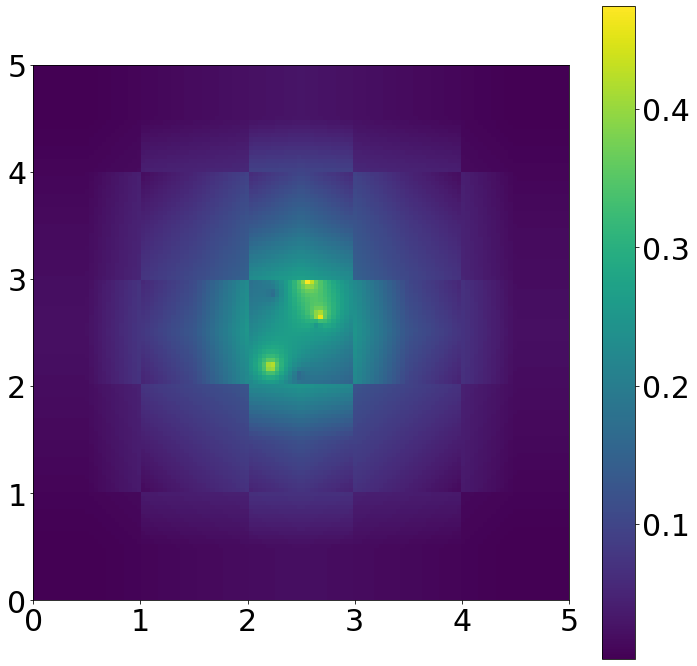

In [888]:
o=post.reconstruct_coupling(phi, 1, t)
rec_coup=o.reconstruction(25)

plt.imshow(rec_coup, extent=[0,L,0,L], origin='lower')
plt.colorbar()
plt.show()

In [863]:
t.pos_s

array([[2.22, 2.18],
       [2.48, 2.1 ],
       [2.24, 2.86],
       [2.57, 2.98],
       [2.65, 2.58],
       [2.67, 2.65]])

In [864]:
ratio=15

In [865]:
h_rec=h_ss/ratio 
L=t.x[-1]+h_ss/2

num=int(L//h_rec)
h=L/num
x_rec=np.linspace(h_rec/2, L-h_rec/2, num)

<ipython-input-866-7cc13838a1ea>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])


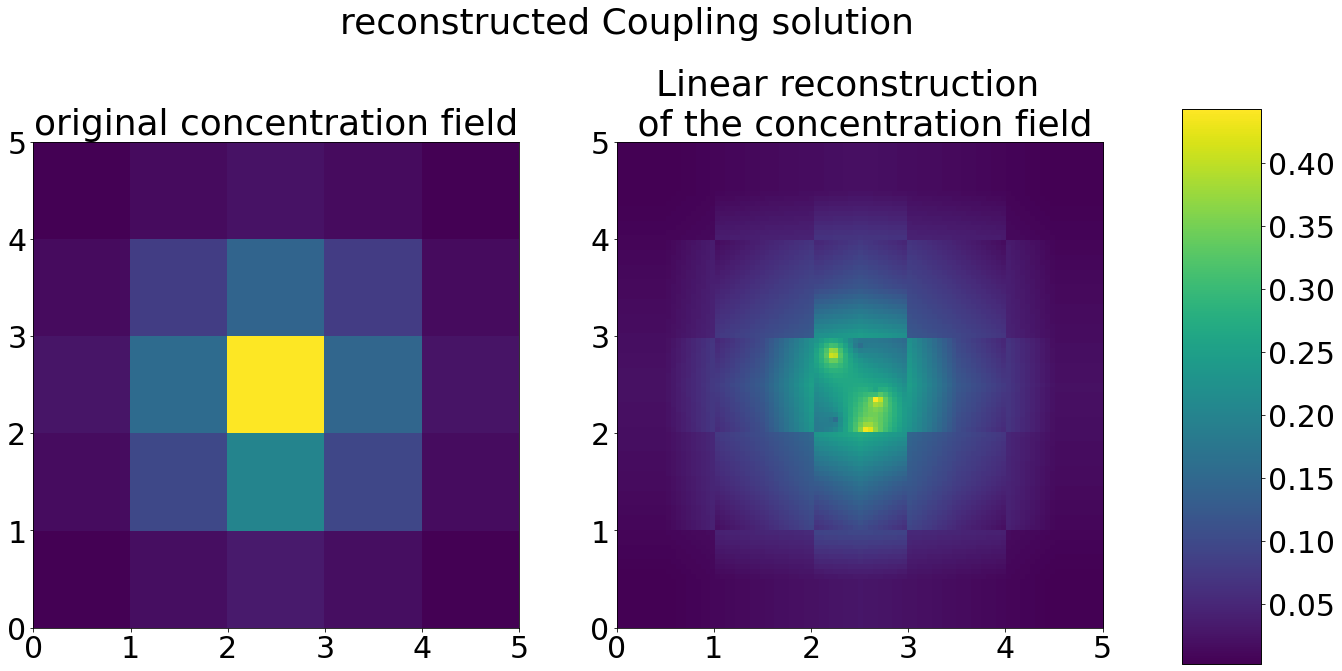

In [866]:

plt.rcParams.update({'font.size': 30})
fig, axs=plt.subplots(1,2, figsize=(22,11))
fig.suptitle("reconstructed Coupling solution")
im=axs[0].imshow(phi_FV.reshape(len(y_ss), len(x_ss)), extent=[0,L,0,L])
axs[0].set_title("original concentration field")
im=axs[1].imshow(rec_coup, extent=[0,L,0,L])
axs[1].set_title("Linear reconstruction  \n of the concentration field")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

[ 0.50394984 -0.15588796 -0.16133194  0.47655643 -0.24881194  0.50603355]


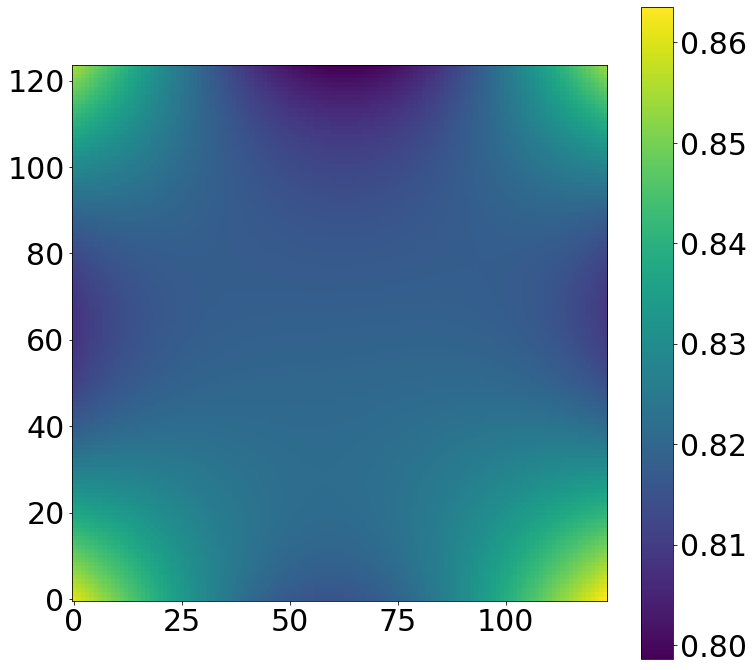

In [892]:
a=full_ss(pos_s, Rv, h_ss/ratio, K_eff, D,L)
SS=a.solve_problem(B_q)
SS=a.reconstruct(a.v, a.phi_q)
plt.show()


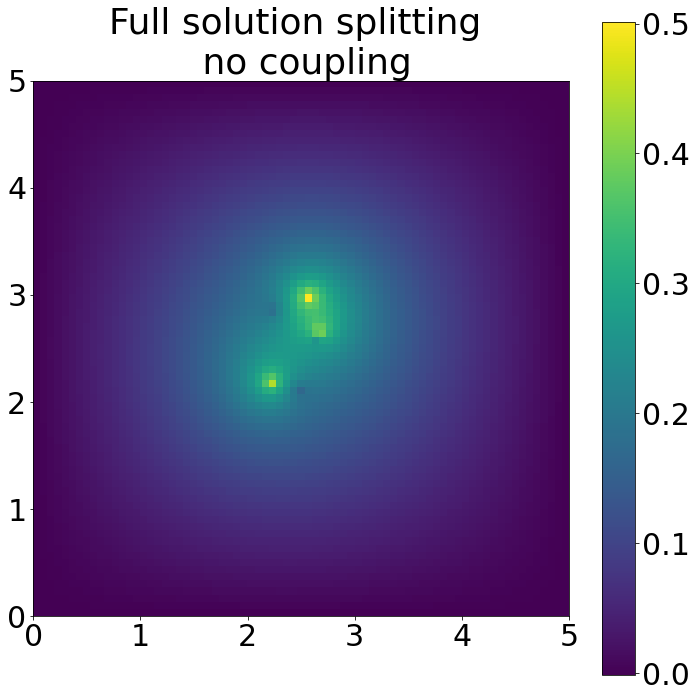

In [868]:
plt.figure(figsize=(12,12))
plt.imshow(SS, origin="lower",extent=[0,L,0,L]); plt.colorbar()

plt.title("Full solution splitting \n no coupling")
plt.show()

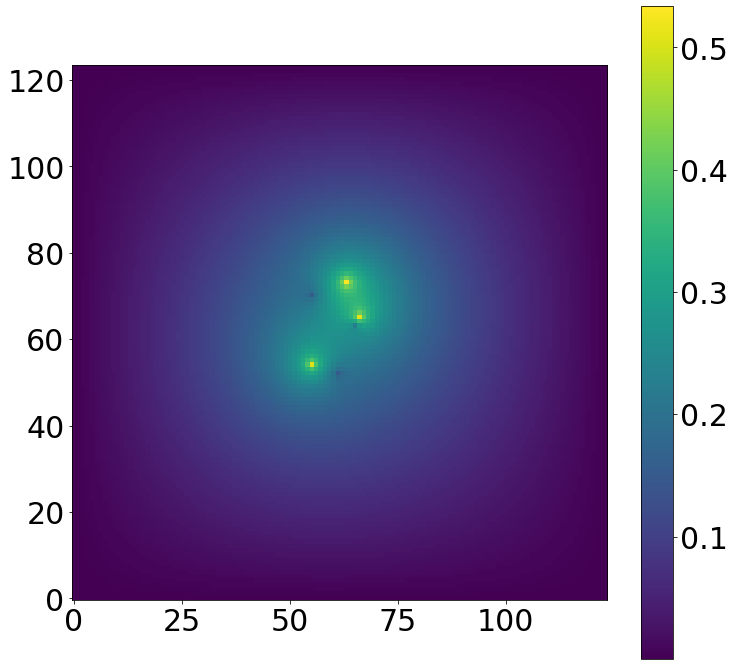

In [891]:
ratio=25
sol, xlen2, ylen2,q_array,_, Y, s_b,x_v, y_v=get_validation(ratio, t, pos_s, B_q, D, K_eff, Rv,L)
plt.figure(figsize=(12,12))
plt.imshow(sol.reshape(ylen2, xlen2), origin='lower'); plt.colorbar()
plt.show()



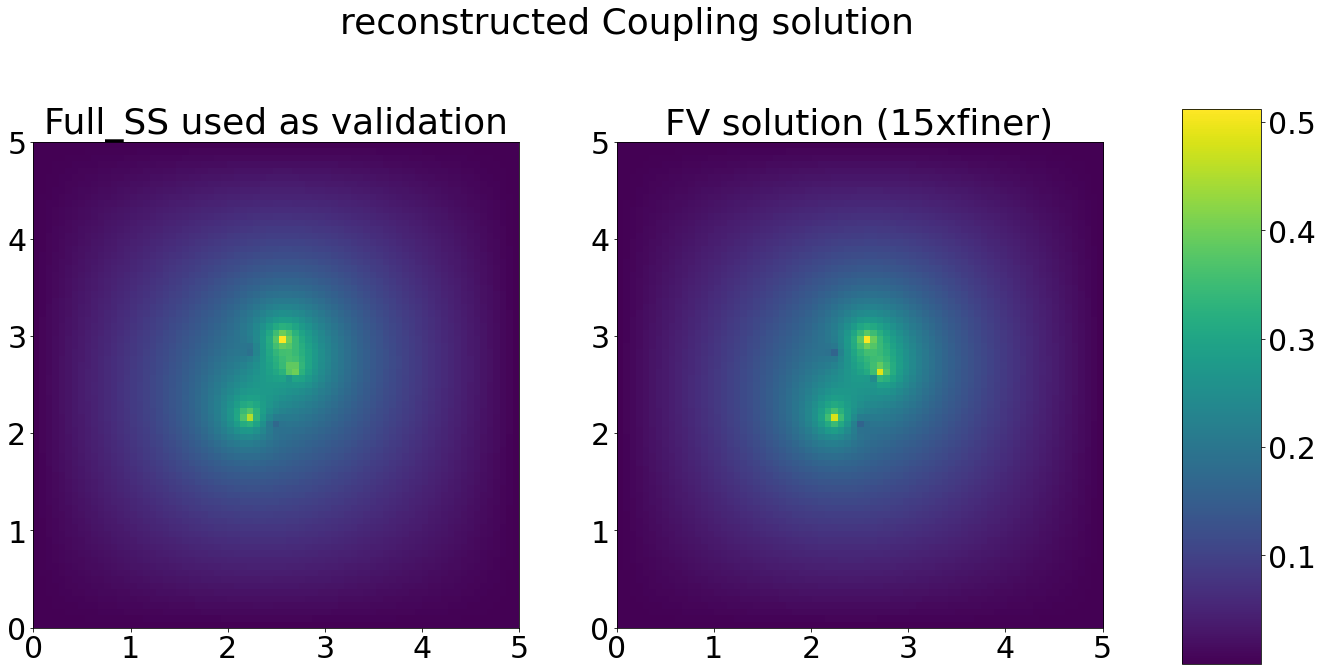

In [870]:

plt.rcParams.update({'font.size': 30})
fig, axs=plt.subplots(1,2, figsize=(22,11))
fig.suptitle("reconstructed Coupling solution")
im=axs[0].imshow(SS, origin="lower",extent=[0,L,0,L])
axs[0].set_title("Full_SS used as validation")
im=axs[1].imshow(sol.reshape(ylen2, xlen2), origin='lower', extent=[0,L,0,L])
axs[1].set_title("FV solution ({}xfiner)".format(ratio))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [871]:
print(sol.reshape(ylen2, xlen2).shape)
print(SS.shape)

(75, 75)
(75, 75)


Text(0.5, 1.0, 'zoom in to the source \n block in the FV solution')

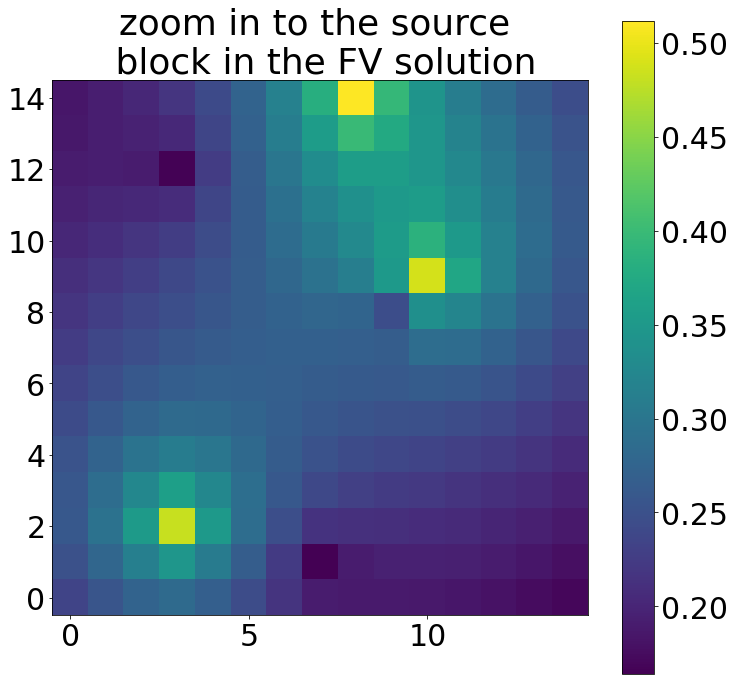

In [872]:
plt.imshow(sol.reshape(ylen2, xlen2)[2*ratio:3*ratio,2*ratio:3*ratio], origin='lower'); plt.colorbar()
plt.title("zoom in to the source \n block in the FV solution")

In [873]:
print(np.around(pos_s, decimals=2))
print(B_q)

[[2.22 2.18]
 [2.48 2.1 ]
 [2.24 2.86]
 [2.57 2.98]
 [2.65 2.58]
 [2.67 2.65]]
[1 0 0 1 0 1]


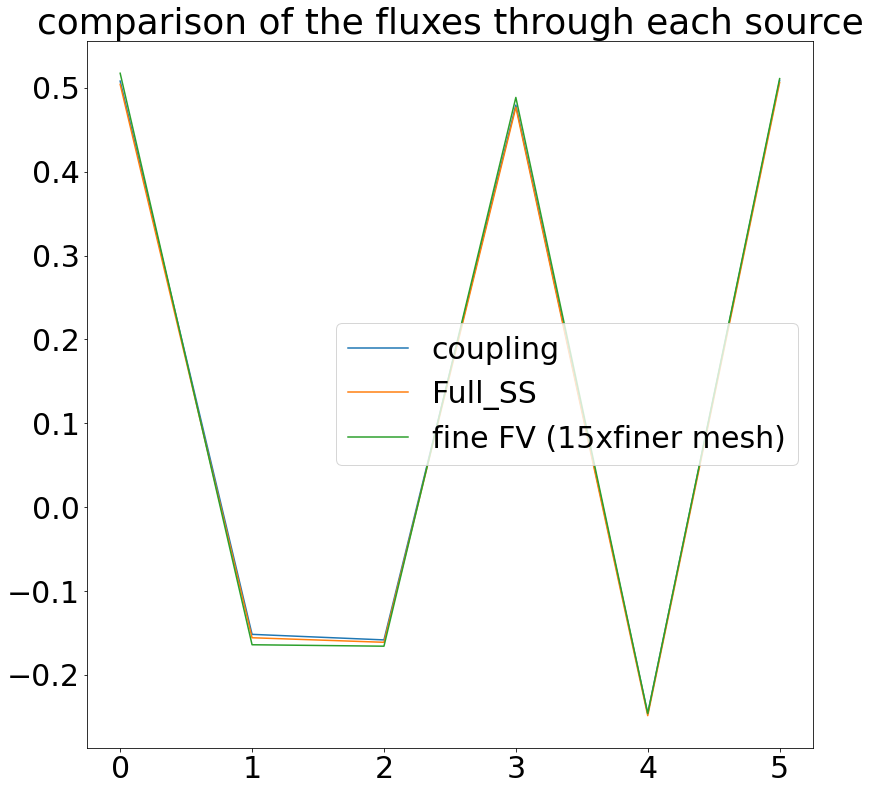

In [874]:


# =============================================================================
# plt.plot(a.x, SS[:,3])
# plt.plot(x_ss, phi_mat[:,3])
# plt.show()
# 
# =============================================================================

plt.figure(figsize=(13,13))

plt.plot(np.arange(S),phi_q, label="coupling")
plt.plot(np.arange(S),a.phi_q, label="Full_SS")
plt.plot(np.arange(S),q_array, label="fine FV ({}xfiner mesh)".format(ratio))
plt.title("comparison of the fluxes through each source")
plt.legend()


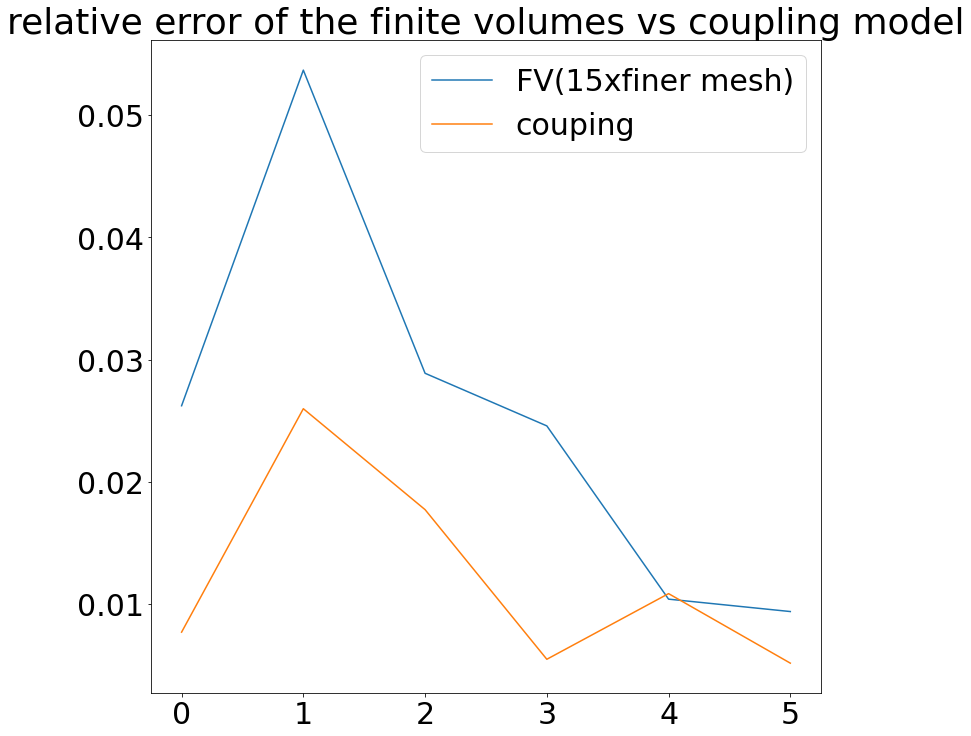

In [875]:
error_fv=(q_array-a.phi_q)/a.phi_q
error_coup=(phi_q-a.phi_q)/a.phi_q
plt.figure(figsize=(12,12))

plt.plot(np.arange(S),np.abs(error_fv), label="FV({}xfiner mesh)".format(ratio))
plt.plot(np.arange(S),np.abs(error_coup), label="couping")
plt.title("relative error of the finite volumes vs coupling model")
plt.legend()

In [876]:
x_index_FV=np.array(len(pos_s))
x_index_SS=np.array(len(pos_s))
x_index_coup=np.array(len(pos_s))
o.x,o.y=post.get_sub_x_y(t.x, t.y, t.h, ratio)

for i in pos_s:
    x_index_FV=np.append(x_index_FV, np.argmin(np.abs(x_v-i[0])))
    x_index_SS=np.append(x_index_SS, np.argmin(np.abs(a.x-i[0])))
    x_index_coup=np.append(x_index_coup, np.argmin(np.abs(x_v-i[0])))
    


In [877]:
phi_q

array([ 0.50801577, -0.15164232, -0.15826041,  0.47940525, -0.2459109 ,
        0.50881231])

IndexError: index 33 is out of bounds for axis 1 with size 24

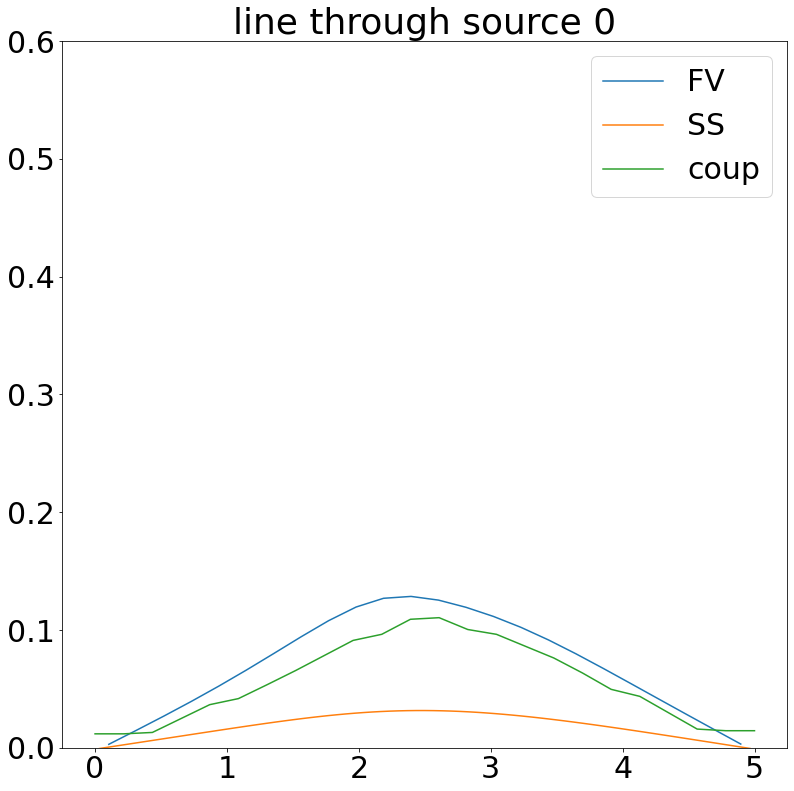

<Figure size 936x936 with 0 Axes>

In [885]:
o=post.reconstruct_coupling(phi, 1, t)
rec_coup=o.reconstruction(ratio)

for i in range(S):
    plt.figure(figsize=(13,13))
    plt.plot(y_v, sol.reshape(ylen2,xlen2)[:,x_index_FV[i]], label="FV")
    plt.plot(a.y, SS[:,x_index_SS[i]], label="SS")
    plt.plot(np.linspace(0,L,rec_coup.shape[0]), rec_coup[:,x_index_coup[i]], label="coup")
    plt.title("line through source {}".format(i, np.around(phi_q[i], decimals=2)))
    plt.ylim(0,0.6)
    plt.legend()

<Figure size 864x864 with 0 Axes>

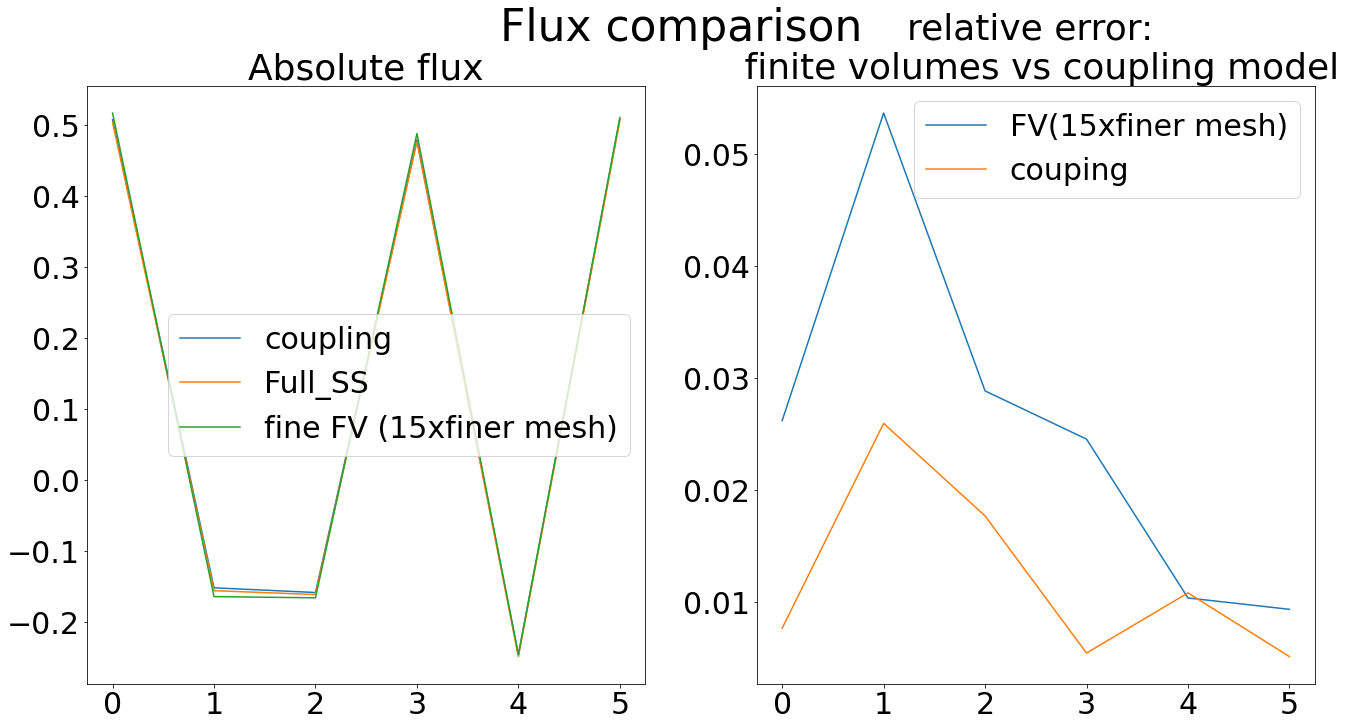

In [879]:
error_fv=(q_array-a.phi_q)/a.phi_q
error_coup=(phi_q-a.phi_q)/a.phi_q
plt.figure(figsize=(12,12))

plt.rcParams.update({'font.size': 30})
fig, axs=plt.subplots(1,2, figsize=(22,11))
fig.suptitle("Flux comparison", fontsize=44)
im=axs[0].plot(np.arange(S),phi_q, label="coupling")
im=axs[0].plot(np.arange(S),a.phi_q, label="Full_SS")
im=axs[0].plot(np.arange(S),q_array, label="fine FV ({}xfiner mesh)".format(ratio))
axs[0].legend()
axs[0].set_title("Absolute flux")
im=axs[1].plot(np.arange(S),np.abs(error_fv), label="FV({}xfiner mesh)".format(ratio))
im=axs[1].plot(np.arange(S),np.abs(error_coup), label="couping")
plt.title("relative error: \n finite volumes vs coupling model")
plt.legend()

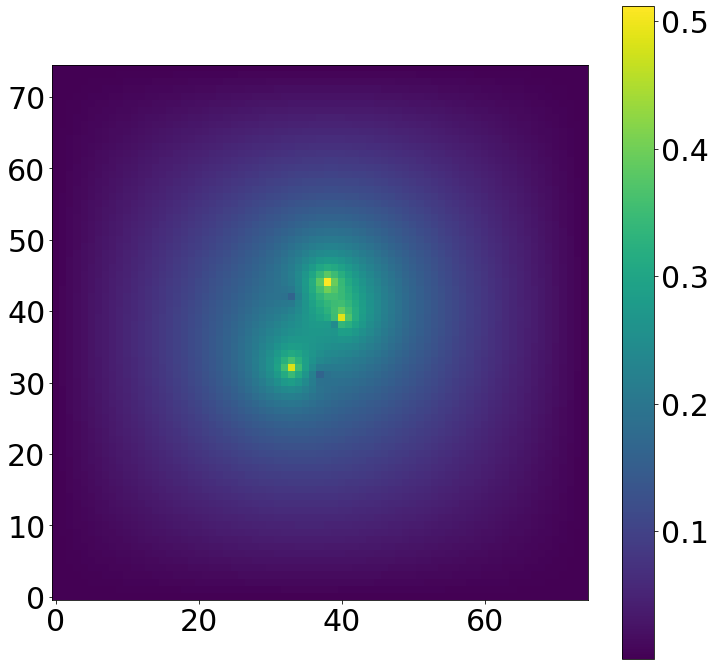

In [880]:
ratio=15
sol, xlen2, ylen2,q_array,_, Y, s_b,x_v, y_v=get_validation(ratio, t, pos_s, B_q, D, K_eff, Rv,L)
plt.imshow(sol.reshape(ylen2, xlen2), origin='lower'); plt.colorbar()
plt.show()



<Figure size 864x864 with 0 Axes>

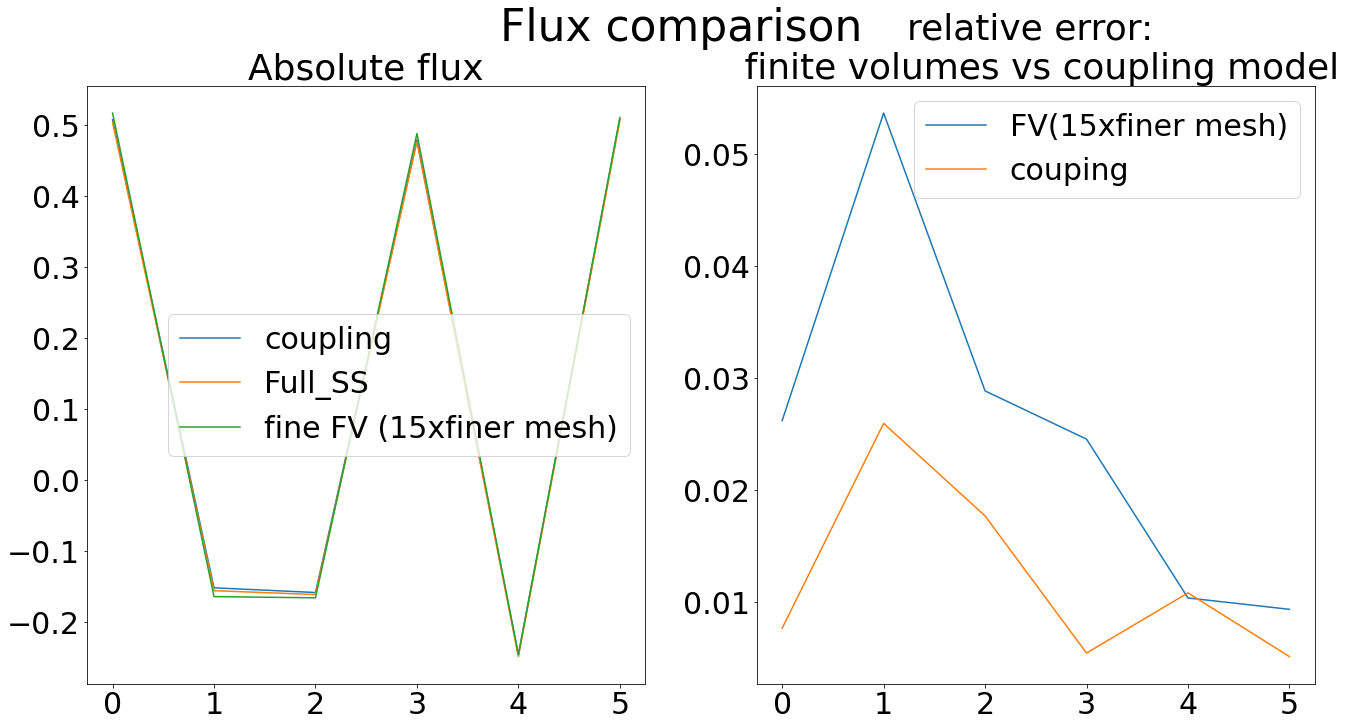

In [881]:

error_fv=(q_array-a.phi_q)/a.phi_q
error_coup=(phi_q-a.phi_q)/a.phi_q
plt.figure(figsize=(12,12))

plt.rcParams.update({'font.size': 30})
fig, axs=plt.subplots(1,2, figsize=(22,11))
fig.suptitle("Flux comparison", fontsize=44)
im=axs[0].plot(np.arange(S),phi_q, label="coupling")
im=axs[0].plot(np.arange(S),a.phi_q, label="Full_SS")
im=axs[0].plot(np.arange(S),q_array, label="fine FV ({}xfiner mesh)".format(ratio))
axs[0].legend()
axs[0].set_title("Absolute flux")
im=axs[1].plot(np.arange(S),np.abs(error_fv), label="FV({}xfiner mesh)".format(ratio))
im=axs[1].plot(np.arange(S),np.abs(error_coup), label="couping")
plt.title("relative error: \n finite volumes vs coupling model")
plt.legend()





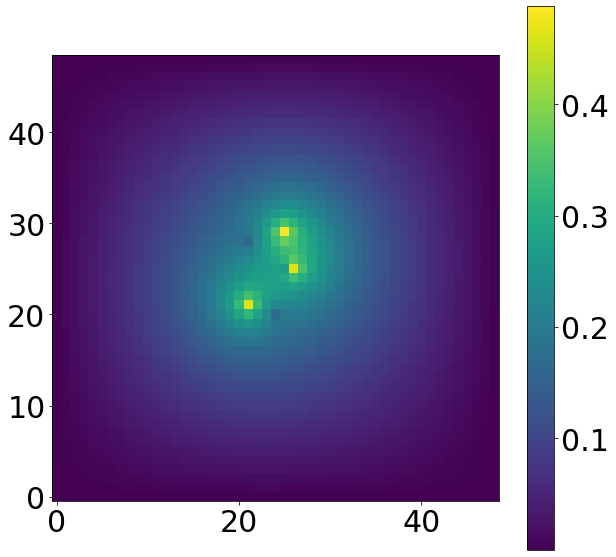

<Figure size 864x864 with 0 Axes>

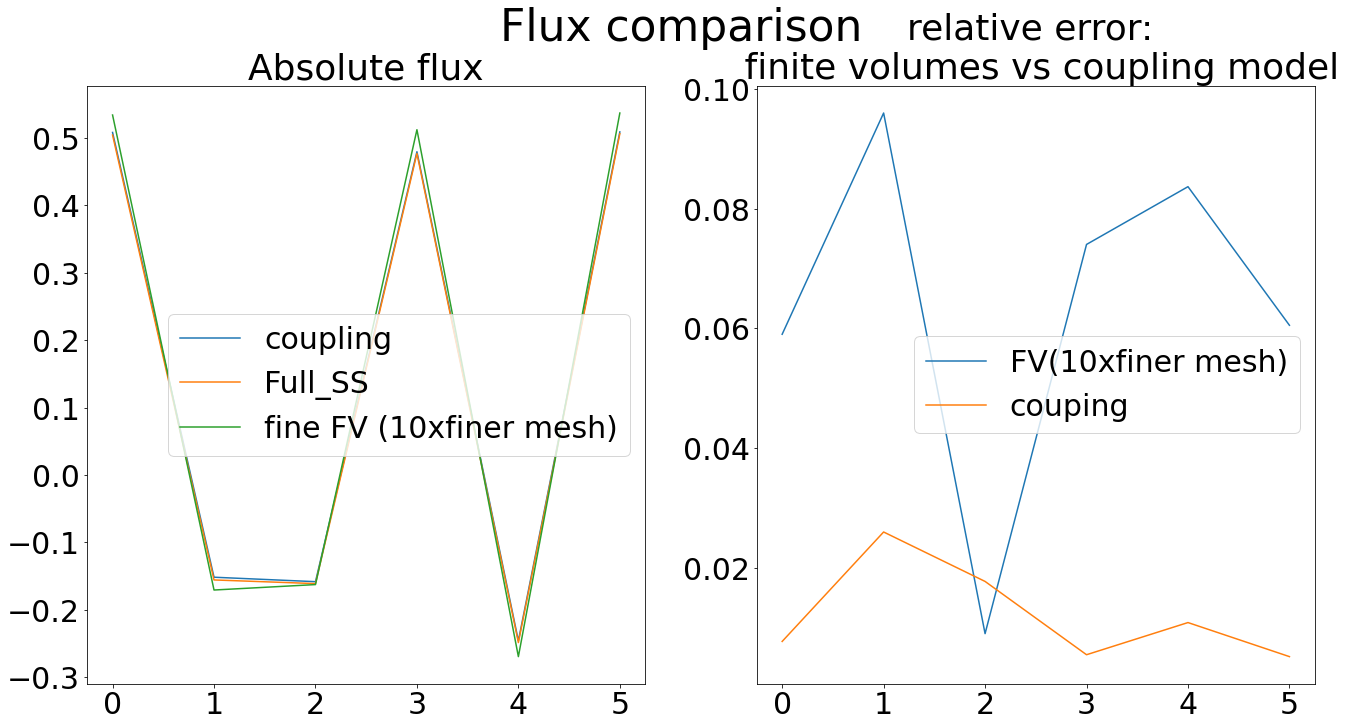

In [882]:
ratio=10
plt.figure(figsize=(10,10))
sol, xlen2, ylen2,q_array,_, Y, s_b,x_v, y_v=get_validation(ratio, t, pos_s, B_q, D, K_eff, Rv,L)
plt.imshow(sol.reshape(ylen2, xlen2), origin='lower'); plt.colorbar()
plt.show()


error_fv=(q_array-a.phi_q)/a.phi_q
error_coup=(phi_q-a.phi_q)/a.phi_q
plt.figure(figsize=(12,12))

plt.rcParams.update({'font.size': 30})
fig, axs=plt.subplots(1,2, figsize=(22,11))
fig.suptitle("Flux comparison", fontsize=44)
im=axs[0].plot(np.arange(S),phi_q, label="coupling")
im=axs[0].plot(np.arange(S),a.phi_q, label="Full_SS")
im=axs[0].plot(np.arange(S),q_array, label="fine FV ({}xfiner mesh)".format(ratio))
axs[0].legend()
axs[0].set_title("Absolute flux")
im=axs[1].plot(np.arange(S),np.abs(error_fv), label="FV({}xfiner mesh)".format(ratio))
im=axs[1].plot(np.arange(S),np.abs(error_coup), label="couping")
plt.title("relative error: \n finite volumes vs coupling model")
plt.legend()



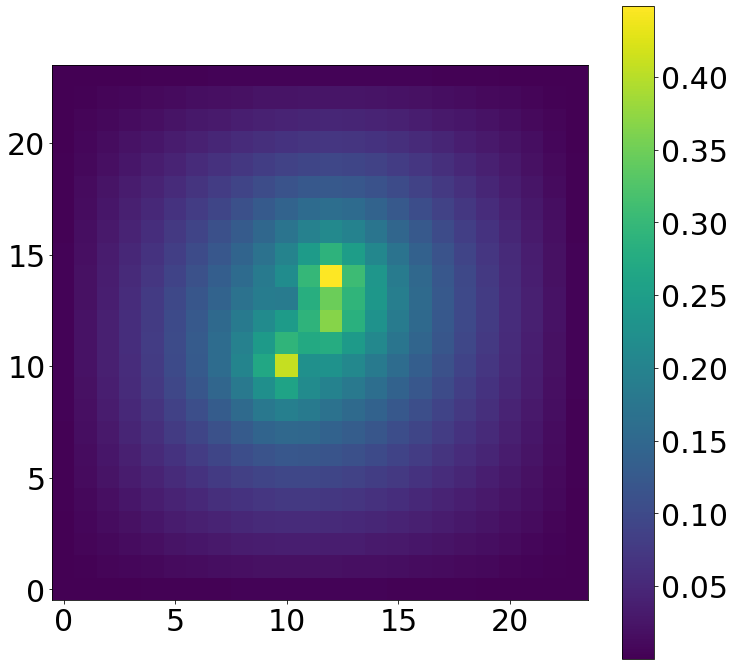

<Figure size 864x864 with 0 Axes>

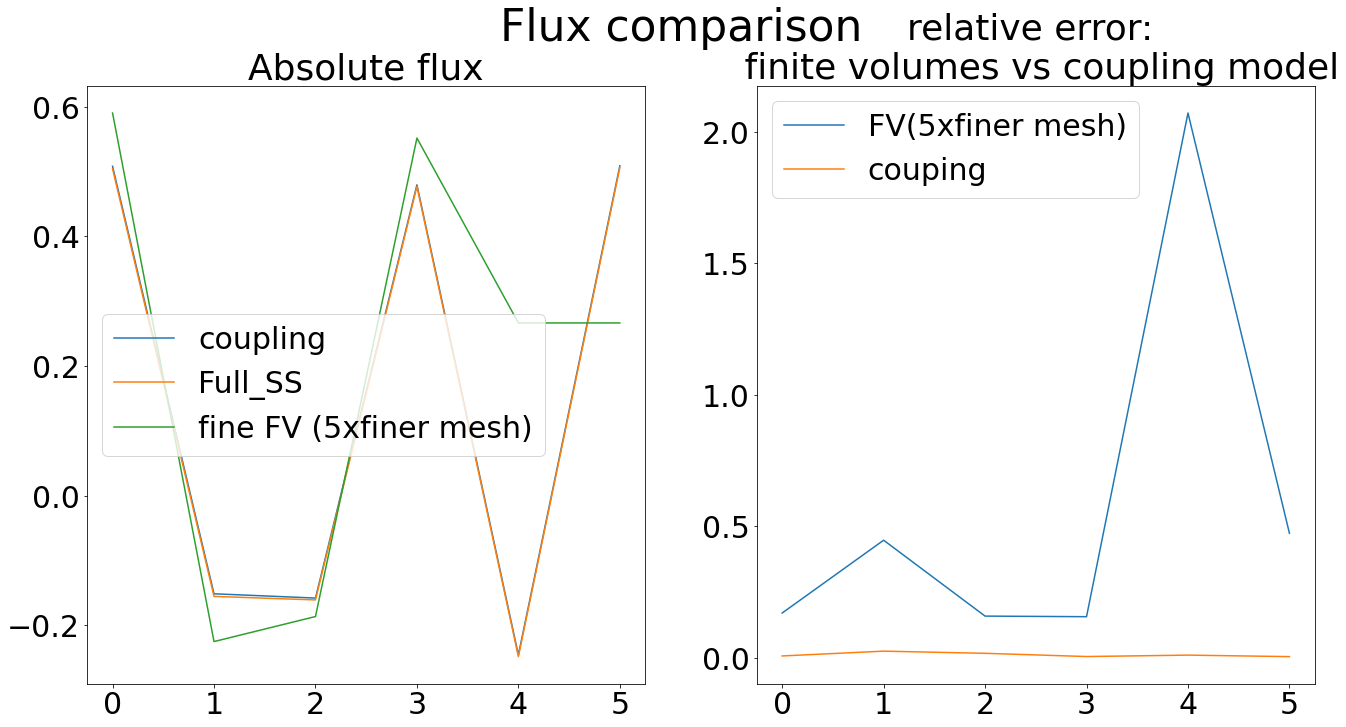

In [883]:
ratio=5
sol, xlen2, ylen2,q_array,_, Y, s_b,x_v, y_v=get_validation(ratio, t, pos_s, B_q, D, K_eff, Rv,L)
plt.imshow(sol.reshape(ylen2, xlen2), origin='lower'); plt.colorbar()
plt.show()


error_fv=(q_array-a.phi_q)/a.phi_q
error_coup=(phi_q-a.phi_q)/a.phi_q
plt.figure(figsize=(12,12))

plt.rcParams.update({'font.size': 30})
fig, axs=plt.subplots(1,2, figsize=(22,11))
fig.suptitle("Flux comparison", fontsize=44)
im=axs[0].plot(np.arange(S),phi_q, label="coupling")
im=axs[0].plot(np.arange(S),a.phi_q, label="Full_SS")
im=axs[0].plot(np.arange(S),q_array, label="fine FV ({}xfiner mesh)".format(ratio))
axs[0].legend()
axs[0].set_title("Absolute flux")
im=axs[1].plot(np.arange(S),np.abs(error_fv), label="FV({}xfiner mesh)".format(ratio))
im=axs[1].plot(np.arange(S),np.abs(error_coup), label="couping")
plt.title("relative error: \n finite volumes vs coupling model")
plt.legend()

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

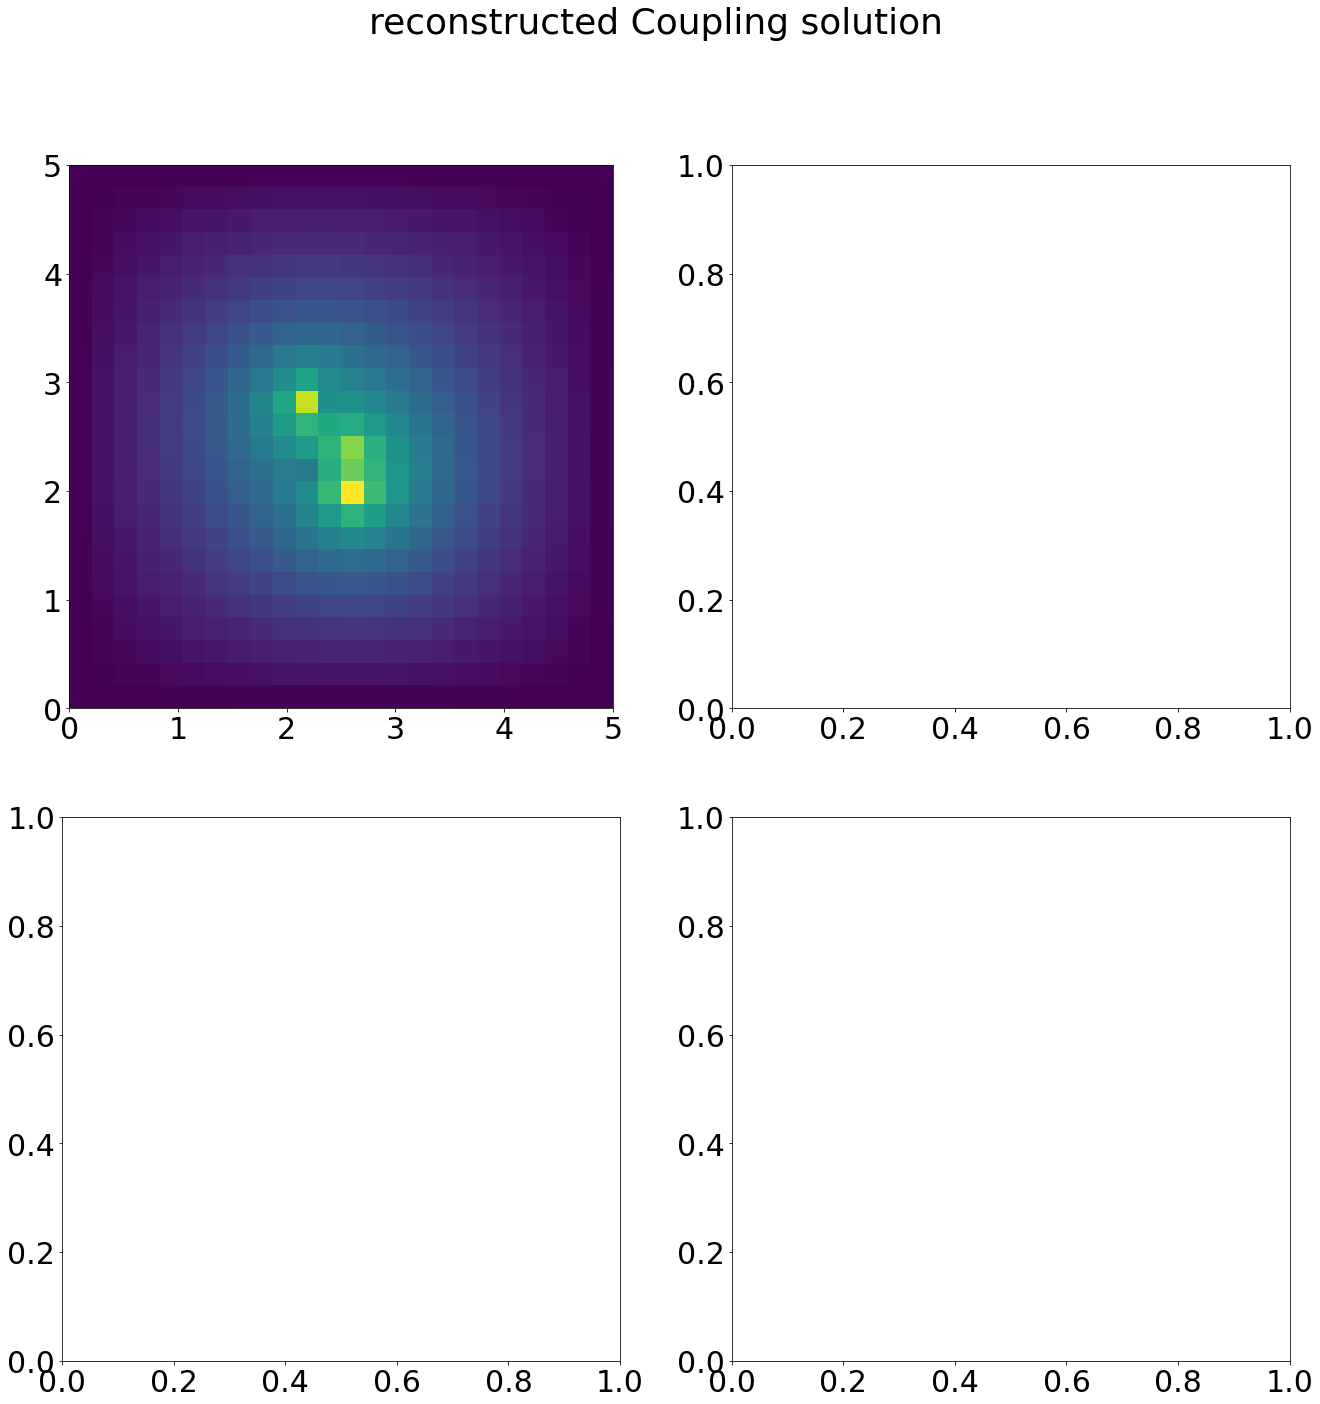

In [884]:
o
plt.rcParams.update({'font.size': 30})
fig, axs=plt.subplots(2,2, figsize=(22,22))
fig.suptitle("reconstructed Coupling solution")
im=axs[0,0].imshow(sol.reshape(ylen2, xlen2), extent=[0,L,0,L])
axs[0].set_title("original concentration field")
im=axs[1].imshow(rec, extent=[0,L,0,L])
axs[1].set_title("Linear reconstruction  \n of the concentration field")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

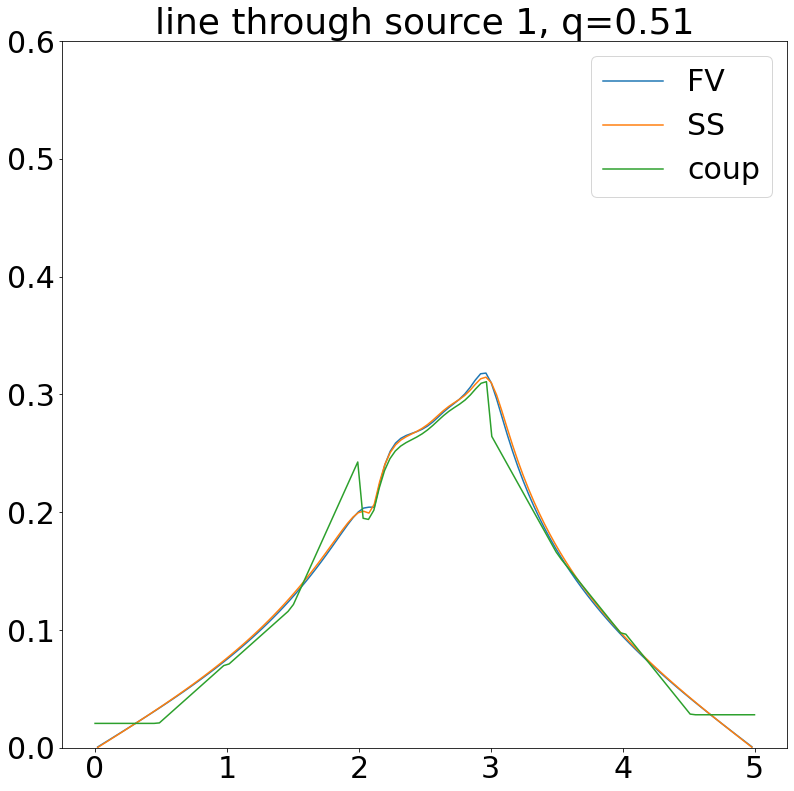

In [896]:
plt.figure(figsize=(13,13))
plt.plot(y_v, sol.reshape(ylen2,xlen2)[:,60], label="FV")
plt.plot(a.y, SS[:,60], label="SS")
plt.plot(np.linspace(0,L,rec_coup.shape[0]), rec_coup[:,60], label="coup")
plt.title("line through source {}, q={}".format(i, np.around(phi_q[0], decimals=2)))
plt.ylim(0,0.6)
plt.legend()

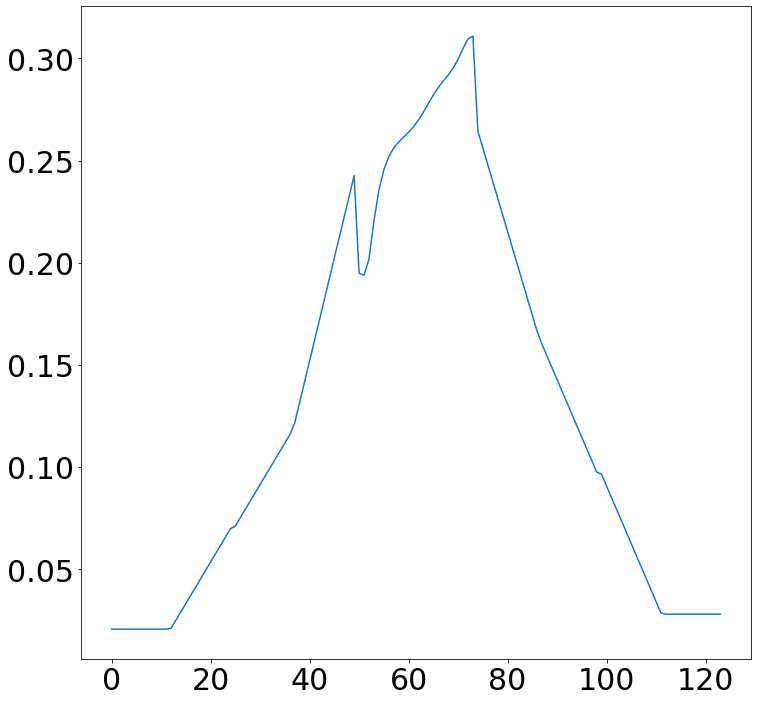

In [890]:
plt.plot(rec_coup[:,60])

In [ ]:
np.sqrt(np.sum((pos_s[-1]-pos_s[-2])**2))

In [ ]:
h_ss

In [ ]:
h_ss/25

In [894]:
phi_q

array([ 0.50801577, -0.15164232, -0.15826041,  0.47940525, -0.2459109 ,
        0.50881231])

In [895]:
x_index_coup

array([ 6, 33, 37, 33, 38, 39, 40])